In [81]:
from warnings import warn
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy
from IPython.display import HTML
from matplotlib import animation
from scipy import signal
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.signal.windows import gaussian

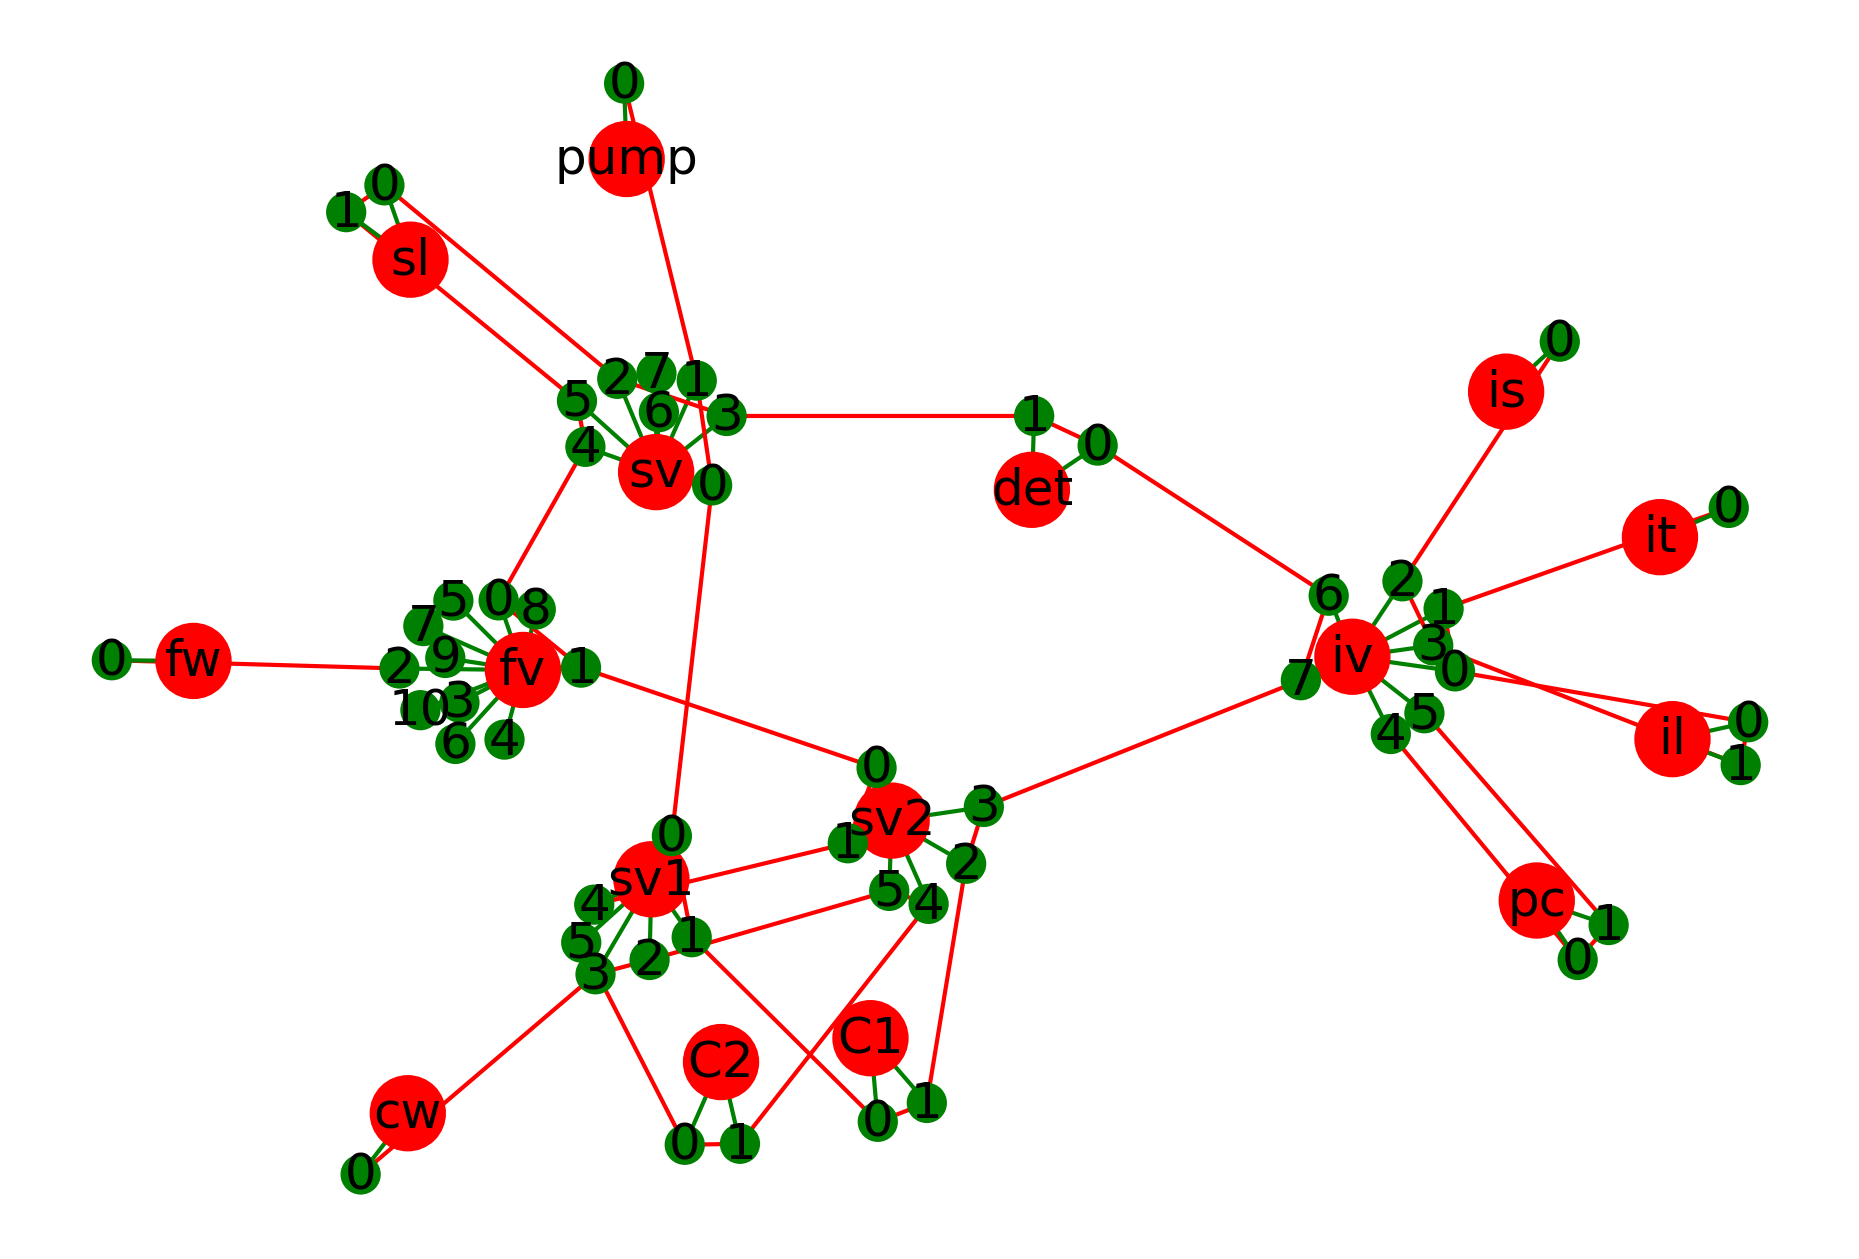

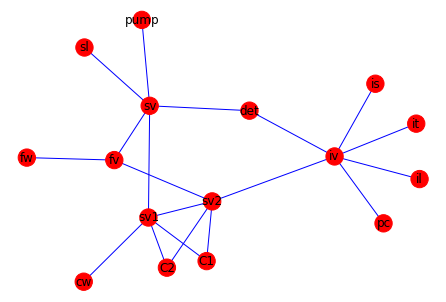

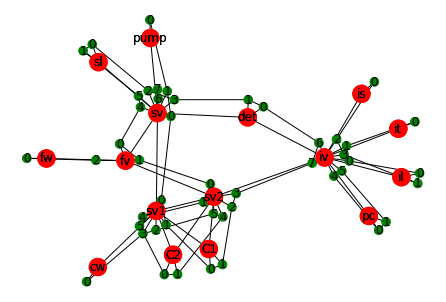

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in true_divide
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:221: RuntimeWarning: invalid value encountered in true_divide
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


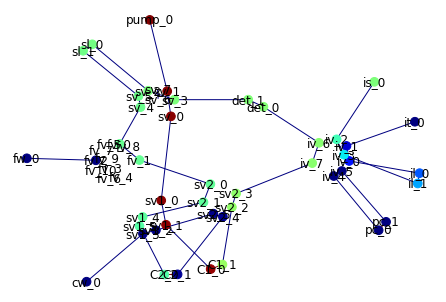

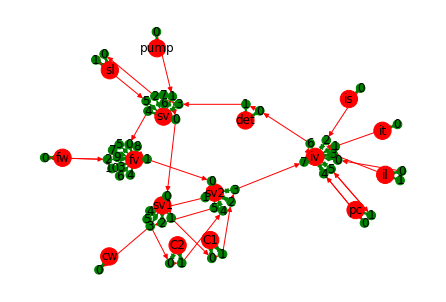

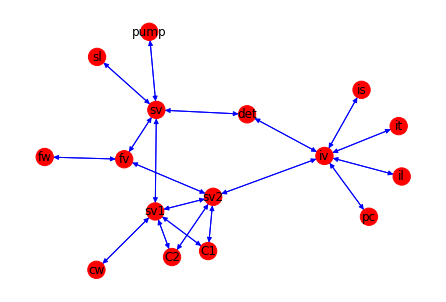

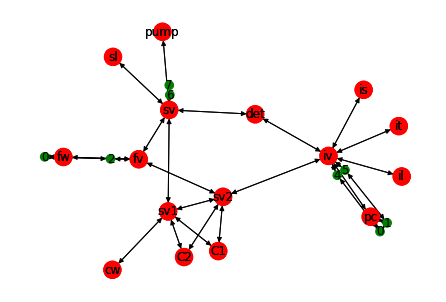

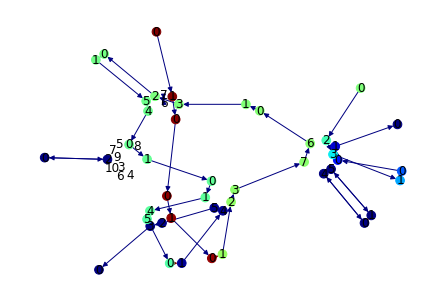

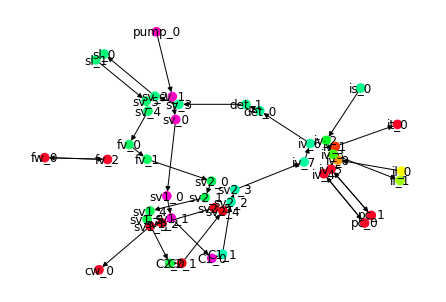

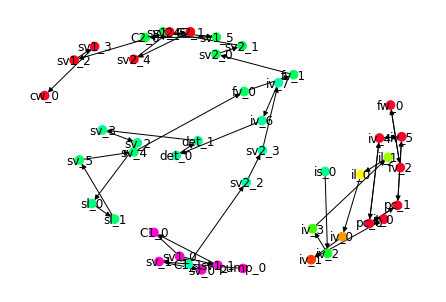

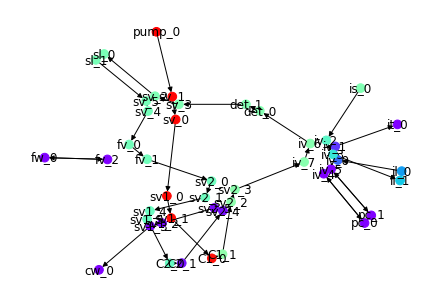

In [112]:
MIN_VOLUME=0.01

PORT_CONNECTION={"type":"port_connection","edge_color":"r","weight":0.005}
INTERNAL_PORT_CONNECTION ={"type":"internal_port_connection","edge_color":"r","weight":0.03}
ELEMENT_CONNECTION={"type":"element_connection","edge_color":"b","weight":0.1}
ELE_PORT_RELATION={"type":"ele_port_relation","edge_color":"g","weight":0.2}

CONNECTION_TYPES={E["type"]:E for E in [
    PORT_CONNECTION,
    ELEMENT_CONNECTION,
    ELE_PORT_RELATION,
    INTERNAL_PORT_CONNECTION,
]}

PORT={"type":"port","node_color":"g","node_size":75}
FLOW_ELEMENT={"type":"flow_element","node_color":"r","node_size":300}

NODE_TYPES={N["type"]:N for N in [
    PORT,
    FLOW_ELEMENT
]}

class GraphMixin():
    def __init__(self,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self._graph=nx.Graph()

    def add_connection(self,node1,node2,**kwargs):
        self._graph.add_edge(node1,node2,**kwargs)

    def remove_connection(self,node1,node2):
            self._graph.remove_edge(node1,node2,)

    def add_node(self,name,**kwargs):
        if name not in self._graph.nodes:
            self._graph.add_node(name,**kwargs)
        else:
            pass

    def get_graph(self):
        g = nx.Graph()
        for node in self._graph.nodes(data=True):
            if isinstance(node[0],GraphMixin):
                sg = node[0].get_graph()
                g.add_nodes_from(sg.nodes(data=True))
                g.add_edges_from(sg.edges(data=True))
#           else:
            g.add_nodes_from([node])

        g.add_edges_from(self._graph.edges(data=True))
        return g

    @property
    def graph(self):
        return self.get_graph()

class FlowSetup(GraphMixin):
    connection_type="flow_element_connection"
    connection_weight=0.5
    node_type="flow_element"
    ele_dist=100

    def calc_positions(self):
        fixed_nodes=[]
        g=self.get_element_graph()
        pos=nx.spring_layout(
            g,
            pos=nx.kamada_kawai_layout(g,
                                       pos= nx.spectral_layout(g),
                                       ),
            k=10,
            iterations=10000,
            scale=None
        )

        for node in self._graph.nodes:
            if isinstance(node,FlowElement):
                nodepositions = node.calc_positions()
                for n,nodepos in nodepositions.items():
                    nodepos += pos[node]
                pos.update(nodepositions)

        g = self.get_detail_graph()
        for node,type in nx.get_node_attributes(g,"type").items():
            if type == FLOW_ELEMENT["type"]:
                fixed_nodes.append(node)

        pos.update(
            nx.spring_layout(
                g,
                k=3,
                #pos=nx.kamada_kawai_layout(
                #    g,
               #     pos=nx.spring_layout(
                #        g,
                        pos=pos,
                 #       iterations=1,
                  #      scale=None,
                   #     fixed=fixed_nodes,
                   # ),
                    #scale=None,
                #),
                iterations=1000,
                scale=None,
                fixed=fixed_nodes,
            )
        )

        return pos

    def get_graph(self, directed=False,direction="calc_pressure"):
        g=super().get_graph()
        if not directed:
            return g

        g=g.to_directed()
        edgs_to_remove=[]
        pressures=nx.get_node_attributes(g,direction)
        for e in g.edges:
            if not (e[0] in pressures and e[1] in pressures):
                continue
            if pressures[e[0]] is None or pressures[e[1]] is None:
                continue
            if pressures[e[0]]<pressures[e[1]]:
                edgs_to_remove.append(e)
        g.remove_edges_from(edgs_to_remove)
        return g

    def connect_ports(self,p1,p2,resistance=1,volume=MIN_VOLUME):
        if isinstance(p1,FlowElement):
            p1=(p1,0)
        if isinstance(p2,FlowElement):
            p2=(p2,0)

        self.add_node(p1[0],**FLOW_ELEMENT)
        self.add_node(p2[0],**FLOW_ELEMENT)
        self.add_connection(p1[0],p2[0],**ELEMENT_CONNECTION)
        self.add_connection(p1[0].get_port(p1[1]),p2[0].get_port(p2[1]),**PORT_CONNECTION,resistance=resistance,volume=volume)

    def get_detail_graph(self,with_flow=False):
        if with_flow:
            self.calc_pressures()
        g=self.get_graph(directed=with_flow)
        n_pre=0
        while len(g.nodes)!=n_pre:
            n_pre=len(g.nodes)
            n2rem=[]
            for n,d in g.nodes(data=True):
                if isinstance(n,GraphMixin):
                    n2rem.append(n)
                    continue
                if d["type"]==FLOW_ELEMENT["type"]:
                    continue
            for n in set(n2rem):
                g.remove_node(n)

        return g

    def get_port_graph(self,with_flow=False):
        if with_flow:
            self.calc_pressures()
        g=self.get_graph(directed=with_flow)
        n2rem=[]
        for n,d in g.nodes(data=True):
            if d["type"]!=PORT["type"]:
                n2rem.append(n)
        for n in set(n2rem):
            g.remove_node(n)
        return g

    def get_flat_flow(self,with_flow=False):
        if with_flow:
            self.calc_pressures()
        g=self.get_graph(directed=with_flow)
        n_pre=0
        while len(g.nodes)!=n_pre:
            n_pre=len(g.nodes)
            n2rem=[]
            for n,d in g.nodes(data=True):
                if d["type"]==FLOW_ELEMENT["type"]:
                    continue
                ct=g[n]
                if len(ct) <2:
                    n2rem.append(n)
            for n in set(n2rem):
                g.remove_node(n)

        return g

    def get_element_graph(self,with_flow=False):
        if with_flow:
            self.calc_pressures()
        g=self.get_graph(directed=with_flow)
        n2rem=[]
        for n in g.nodes:
            if isinstance(n,GraphMixin):
                continue
            n2rem.append(n)
        for n in set(n2rem):
            g.remove_node(n)

        return g

    def calc_pressures(self,to_nodes=True,threshold=0.001,max_iter=100000):
        g = self.get_port_graph()

        adj = nx.to_numpy_array(g,weight=None)
        adj_res = nx.to_numpy_array(g,weight="resistance")
        adj_imp=np.nan_to_num(adj*1/adj_res)
        assert not np.isnan(adj_res).any()
        assert not np.isnan(adj_imp).any()

        or_press = np.array([n[1]["pressure"] for n in g.nodes(data=True)])

        press_mask=or_press.astype(float)
        press = np.nan_to_num(press_mask)
        press_mask=~np.isnan(press_mask)
        assert not np.isnan(press).any()
        pre_press=np.zeros_like(press)
        for i in range(max_iter):
            press = (adj_imp*press).sum(1)/adj_imp.sum(1)
            press = np.nan_to_num(press)
            press[press_mask]=or_press[press_mask]
            if (press-pre_press).max() <=threshold:
                #print(i,(press-pre_press).max())
                break
            pre_press=press
        if to_nodes:
            nx.set_node_attributes(self._graph,values=dict(zip(g.nodes,press)),name="calc_pressure")

        return dict(zip(g.nodes,press))

class FlowElement(GraphMixin):
    _ele_count=0

    def __init__(self, ports=0,internal_connections=[], pressure=None,resistance=1,name=None,volume=MIN_VOLUME, *args, **kwargs):
        self._number=self._ele_count
        self._port_names = ["port_{}_{}".format(i,self._number) for i in range(ports)]
        FlowElement._ele_count+=1
        if not isinstance(pressure,(list,tuple)):
            pressure=[pressure]*ports
        if not isinstance(resistance,(list,tuple)):
           resistance=[resistance]*len(internal_connections)

        assert len(pressure)==ports

        if name is None:
            name = "fe_{}".format(self._number)
        self.name=name

        super().__init__(*args, **kwargs)
        self.add_node(self.name,**FLOW_ELEMENT)
        for i in range(ports):
            p=self._port_names[i]
            self.add_node(p,**PORT,number=i,pressure=pressure[i],label="{}_{}".format(self.name,i),flow_ele=self)
            self.add_connection(self.name,p,**ELE_PORT_RELATION)

        for i,ic in enumerate(internal_connections):
                self.add_internal_connection(self._port_names[ic[0]],self._port_names[ic[1]],resistance=resistance[i],volume=volume)

        self.volume=volume

    def add_internal_connection(self,port1,port2,resistance=1,volume=MIN_VOLUME):
        self.add_connection(port1,port2,**INTERNAL_PORT_CONNECTION,resistance=resistance,volume=volume)

    def __str__(self):
        return self.name

    def calc_positions(self):
        pos={}
        ports=[]
        eles=[]
        for node,type in nx.get_node_attributes(self._graph,"type").items():
            if type == FLOW_ELEMENT["type"]:
                eles.append(node)
            if type == PORT["type"]:
                ports.append(node)

        l=len(eles)
        if l >1:
            l=l/(2*np.pi)
            r=1
            for i,c in enumerate(eles):
                pos[c] = np.array([r*np.sin(i/l),r*np.cos(i/l)])
        else:
            for c in eles:
                pos[c] = np.array([0.0,0.0])



        l=len(ports)/(2*np.pi)
        r=3
        for i,c in enumerate(ports):
            pos[c] = np.array([r*np.sin(i/l),r*np.cos(i/l)])

        return pos

    def get_port(self,i):
        return self._port_names[i]

    @property
    def port(self):
        if len(self._port_names) == 1:
            return self.get_port(0)
        else:
            return self.get_port


class FlowSource(FlowElement):
    prefix="source"
    def __init__(self,pressure=100,*args,**kwargs):
            super().__init__(ports=1,pressure=pressure,*args,**kwargs)

class FlowDrain(FlowElement):
    prefix="drain"
    def __init__(self,pressure=0,*args,**kwargs):
            super().__init__(ports=1,pressure=pressure,*args,**kwargs)


class Column(FlowElement):
    def __init__(self,resistance=100,*args,**kwargs):
        super().__init__(ports=2,internal_connections=[(0,1)],pressure=None,resistance=resistance,*args,**kwargs)

class Tubing(FlowElement):
    def __init__(self,resistance=1,*args,**kwargs):
        super().__init__(ports=2,internal_connections=[(0,1)],pressure=None,resistance=resistance,*args,**kwargs)

class Valve(FlowElement):
    def __init__(self,states,ports=None,*args,**kwargs):
        if ports is None:
            ports=-1
            for state in states:
                for pair in state:
                    ports=max(ports,pair[0],pair[1])
            ports+=1
        self._states=states
        self._current_state=0
        super().__init__(ports=ports,internal_connections=states[0],pressure=None,*args,**kwargs)

    def switch(self):
        old_names=[]
        new_names=[]

        for i,ic in enumerate(self._states[self._current_state]):
            self.remove_connection(self._port_names[ic[0]],self._port_names[ic[1]])
            old_names.append((self._port_names[ic[0]],self._port_names[ic[1]]))

        self._current_state=(self._current_state+1)%len(self._states)
        for i,ic in enumerate(self._states[self._current_state]):
            self.add_internal_connection(self._port_names[ic[0]],self._port_names[ic[1]])
            new_names.append((self._port_names[ic[0]],self._port_names[ic[1]]))
        return dict(zip(old_names,new_names))

class nWay2PosValve(Valve):
    def __init__(self,n,*args,**kwargs):
        assert n%2 ==0
        super().__init__(states=[np.arange(n).reshape(-1,2),np.roll(np.arange(n),1).reshape(-1,2)],*args,**kwargs)

class SixPortValve(nWay2PosValve):
    def __init__(self,*args,**kwargs):
        super().__init__(n=6,*args,**kwargs)

class Split(FlowElement):
    def __init__(self,*args,**kwargs):
        super().__init__(ports=3,internal_connections=[(0,1),(0,2)],*args,**kwargs)

fs=FlowSetup()




switch_valve_2=SixPortValve(name="sv2")


injection_valve=nWay2PosValve(8,name="iv")
injection_source=FlowSource(pressure=50,name="is")
injection_trash = FlowDrain(name="it")
injection_loop = Tubing(name="il",volume=5)
pre_column = Column(name="pc",volume=50)

detector=Tubing(name="det",volume=4)

sampling_valve=nWay2PosValve(8,name="sv")
sampling_loop = Tubing(name="sl",volume=0.5)

fractions=8
fraction_valve=Valve(states=[[(0,i+1)] for i in range(fractions+2)],name="fv")
frac_drains=[FlowDrain(name="fd_{}".format(i)) for i in range(fractions)]
frac_wast = FlowDrain(name="fw")

pump=FlowSource(pressure=100,name="pump")
switch_valve_1=SixPortValve(name="sv1")
c1=Column(name="C1",volume=200)
c2=Column(name="C2",volume=200)

cycle_waste=FlowDrain(name="cw")



fs.connect_ports(pump,(sampling_valve,1))
fs.connect_ports((sampling_valve,0),(switch_valve_1,0))
fs.connect_ports((switch_valve_1,1),c1)
fs.connect_ports((c1,1),(switch_valve_2,2))
fs.connect_ports((switch_valve_2,3),(injection_valve,7))

fs.connect_ports((injection_valve,0),injection_loop)
fs.connect_ports((injection_loop,1),(injection_valve,3))
fs.connect_ports((injection_valve,4),pre_column)
fs.connect_ports((pre_column,1),(injection_valve,5))
fs.connect_ports((injection_valve,6),detector)

fs.connect_ports(injection_source,(injection_valve,2))
fs.connect_ports((injection_valve,1),injection_trash)

fs.connect_ports((detector,1),(sampling_valve,3))
fs.connect_ports((sampling_valve,2),sampling_loop)
fs.connect_ports((sampling_loop,1),(sampling_valve,5))
#fs.connect_ports((sampling_valve,4),frac_wast)
fs.connect_ports((sampling_valve,4),(fraction_valve,0))

fs.connect_ports((fraction_valve,2),frac_wast)

fs.connect_ports((fraction_valve,1),(switch_valve_2,0))
fs.connect_ports((switch_valve_2,1),(switch_valve_1,4))

fs.connect_ports((switch_valve_1,5),c2)
fs.connect_ports((c2,1),(switch_valve_2,4))
fs.connect_ports((switch_valve_2,5),(switch_valve_1,2))

fs.connect_ports((switch_valve_1,3),cycle_waste)


#switch_valve_2.switch()
#switch_valve_1.switch()

pos=fs.calc_positions()

g = fs.get_detail_graph()
img_n=0

plt.figure(dpi=300)
nx.draw(g,
        pos=pos,#nx.kamada_kawai_layout(g,
            #                       pos=nx.spring_layout(g,pos=pos,iterations=10000)#pos,
            #                       ),
        with_labels=True,
        labels={node[0]:node[1].get('number',node[0]) for node in g.nodes(data=True)},
        node_color=[ NODE_TYPES.get(node[1]['type'],{"node_color":"k"})["node_color"]  for node in g.nodes(data=True)],
        edge_color=[ CONNECTION_TYPES.get(edge[2]['type'],{"edge_color":"k"})["edge_color"]   for edge in g.edges(data=True)],
        node_size=[ NODE_TYPES.get(node[1]['type'],{"node_size":100})["node_size"]  for node in g.nodes(data=True)],
        )
plt.savefig("figures/untiled3_flow_{}.png".format(img_n))
img_n+=1
plt.show()
plt.close()


g = fs.get_element_graph()
nx.draw(g,
        pos=pos,
        with_labels=True,
        labels={node[0]:node[1].get('label',node[0]) for node in g.nodes(data=True)},
        node_color=[ NODE_TYPES.get(node[1]['type'],{"node_color":"k"})["node_color"]  for node in g.nodes(data=True)],
        edge_color=[ CONNECTION_TYPES.get(edge[2]['type'],{"edge_color":"k"})["edge_color"]   for edge in g.edges(data=True)],
        node_size=[ NODE_TYPES.get(node[1]['type'],{"node_size":100})["node_size"]  for node in g.nodes(data=True)],
        )
plt.savefig("figures/untiled3_flow_{}.png".format(img_n))
img_n+=1
plt.show()
plt.close()

g = fs.get_flat_flow()
nx.draw(g,
        pos=pos,
        with_labels=True,
        labels={node[0]:node[1].get('number',node[0]) for node in g.nodes(data=True)},
        node_color=[ NODE_TYPES.get(node[1]['type'],{"node_color":"k"})["node_color"]  for node in g.nodes(data=True)],
        #edge_color=[ CONNECTION_TYPES.get(edge[2]['type'],{"edge_color":"k"})["edge_color"]   for edge in g.edges(data=True)],
        node_size=[ NODE_TYPES.get(node[1]['type'],{"node_size":100})["node_size"]  for node in g.nodes(data=True)],
        )
plt.savefig("figures/untiled3_flow_{}.png".format(img_n))
img_n+=1
plt.show()
plt.close()

fs.calc_pressures(to_nodes=True)
g = fs.get_port_graph()

nx.draw(g,
        pos=pos,
        with_labels=True,
        labels={node[0]:node[1].get('label',node[0]) for node in g.nodes(data=True)},
        node_color=[ node[1].get('calc_pressure')  for node in g.nodes(data=True)],
        edge_color=[ edge[2].get('resistance')  for edge in g.edges(data=True)],
        node_size=[ NODE_TYPES.get(node[1]['type'],{"node_size":100})["node_size"]  for node in g.nodes(data=True)],
        edge_cmap=plt.cm.jet,
        cmap=plt.cm.jet
        )
#pos = nx.spring_layout(g,iterations=100,)
#ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
#nc = nx.draw_networkx_nodes(g, pos, node_color=colors,
                          #  with_labels=False)
plt.savefig("figures/untiled3_flow_{}.png".format(img_n))
img_n+=1
plt.show()
plt.close()





g = fs.get_detail_graph(with_flow=True)
nx.draw(g,
        pos=pos,
        with_labels=True,
        labels={node[0]:node[1].get('number',node[0]) for node in g.nodes(data=True)},
        node_color=[ NODE_TYPES.get(node[1]['type'],{"node_color":"k"})["node_color"]  for node in g.nodes(data=True)],
        edge_color=[ CONNECTION_TYPES.get(edge[2]['type'],{"edge_color":"k"})["edge_color"]   for edge in g.edges(data=True)],
        node_size=[ NODE_TYPES.get(node[1]['type'],{"node_size":100})["node_size"]  for node in g.nodes(data=True)],
        )
plt.savefig("figures/untiled3_flow_{}.png".format(img_n))
img_n+=1
plt.show()
plt.close()


g = fs.get_element_graph(with_flow=True)
nx.draw(g,
        pos=pos,
        with_labels=True,
        labels={node[0]:node[1].get('label',node[0]) for node in g.nodes(data=True)},
        node_color=[ NODE_TYPES.get(node[1]['type'],{"node_color":"k"})["node_color"]  for node in g.nodes(data=True)],
        edge_color=[ CONNECTION_TYPES.get(edge[2]['type'],{"edge_color":"k"})["edge_color"]   for edge in g.edges(data=True)],
        node_size=[ NODE_TYPES.get(node[1]['type'],{"node_size":100})["node_size"]  for node in g.nodes(data=True)],
        )
plt.savefig("figures/untiled3_flow_{}.png".format(img_n))
img_n+=1
plt.show()
plt.close()

g = fs.get_flat_flow(with_flow=True)
nx.draw(g,
        pos=pos,
        with_labels=True,
        labels={node[0]:node[1].get('number',node[0]) for node in g.nodes(data=True)},
        node_color=[ NODE_TYPES.get(node[1]['type'],{"node_color":"k"})["node_color"]  for node in g.nodes(data=True)],
        #edge_color=[ CONNECTION_TYPES.get(edge[2]['type'],{"edge_color":"k"})["edge_color"]   for edge in g.edges(data=True)],
        node_size=[ NODE_TYPES.get(node[1]['type'],{"node_size":100})["node_size"]  for node in g.nodes(data=True)],
        )
plt.savefig("figures/untiled3_flow_{}.png".format(img_n))
img_n+=1
plt.show()
plt.close()

fs.calc_pressures(to_nodes=True)
g = fs.get_port_graph(with_flow=True)

nx.draw(g,
        pos=pos,
        with_labels=True,
        labels={node[0]:node[1].get('number',node[0]) for node in g.nodes(data=True)},
        node_color=[ node[1].get('calc_pressure')  for node in g.nodes(data=True)],
        edge_color=[ edge[2].get('resistance')  for edge in g.edges(data=True)],
        node_size=[ NODE_TYPES.get(node[1]['type'],{"node_size":100})["node_size"]  for node in g.nodes(data=True)],
        edge_cmap=plt.cm.jet,
        cmap=plt.cm.jet,
        )
plt.savefig("figures/untiled3_flow_{}.png".format(img_n))
img_n+=1
plt.show()
plt.close()

n2h =[ node[0]  for node in g.nodes(data=True) if node[1].get('calc_pressure') is None]
g.remove_nodes_from(n2h)
nx.draw(g,
        pos= pos,
        with_labels=True,
        labels={node[0]:node[1].get('label',node[0]) for node in g.nodes(data=True)},
        node_color=[ node[1].get('calc_pressure')  for node in g.nodes(data=True)],
        #edge_color=[ edge[2].get('resistance')  for edge in g.edges(data=True)],
        node_size=[ NODE_TYPES.get(node[1]['type'],{"node_size":100})["node_size"]  for node in g.nodes(data=True)],
        edge_cmap=plt.cm.gist_rainbow,
        cmap=plt.cm.gist_rainbow,
        )
plt.savefig("figures/untiled3_flow_{}.png".format(img_n))
img_n+=1
plt.show()
plt.close()
nx.draw(g,
        pos= nx.spring_layout(g,pos=nx.kamada_kawai_layout(g,pos= nx.planar_layout(g)),iterations=30),
        with_labels=True,
        labels={node[0]:node[1].get('label',node[0]) for node in g.nodes(data=True)},
        node_color=[ node[1].get('calc_pressure')  for node in g.nodes(data=True)],
        #edge_color=[ edge[2].get('resistance')  for edge in g.edges(data=True)],
        node_size=[ NODE_TYPES.get(node[1]['type'],{"node_size":100})["node_size"]  for node in g.nodes(data=True)],
        edge_cmap=plt.cm.gist_rainbow,
        cmap=plt.cm.gist_rainbow,
        )

plt.savefig("figures/untiled3_flow_{}.png".format(img_n))
img_n+=1
plt.show()
plt.close()

nx.draw(g,
        pos= pos,
        with_labels=True,
        labels={node[0]:node[1].get('label',node[0]) for node in g.nodes(data=True)},
        node_color=[ node[1].get('calc_pressure')  for node in g.nodes(data=True)],
        #edge_color=[ edge[2].get('resistance')  for edge in g.edges(data=True)],
        node_size=[ NODE_TYPES.get(node[1]['type'],{"node_size":100})["node_size"]  for node in g.nodes(data=True)],
        edge_cmap=plt.cm.rainbow,
        cmap=plt.cm.rainbow,
        )

plt.savefig("figures/untiled3_flow_{}.png".format(img_n))
img_n+=1
plt.show()
plt.close()

In [83]:
STEPS_PER_VOL=max(100,10/MIN_VOLUME)
g = fs.get_element_graph()
total_vol=0
vol_indices=[]
for i,n in enumerate(g):
    vol_indices.append(n)
    total_vol+=n.volume

volumes = np.arange(0,total_vol*STEPS_PER_VOL)
vol_correlation=np.zeros_like(volumes)-1
ci=0
for i,e in enumerate(vol_indices):
    v = int(e.volume*STEPS_PER_VOL)
    vol_correlation[ci:ci+v] = i
    ci += v

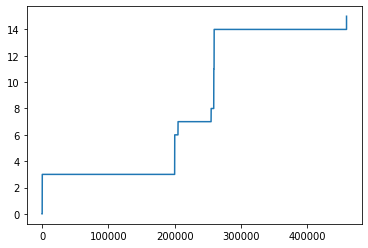

In [84]:
plt.plot(volumes,vol_correlation)

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in true_divide
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:221: RuntimeWarning: invalid value encountered in true_divide


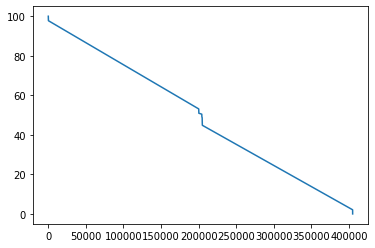

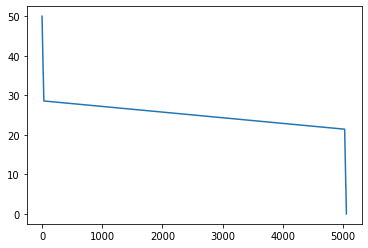

In [113]:
port_pressures=fs.calc_pressures(to_nodes=True)
g = fs.get_port_graph(with_flow=True)
n2h =[ node[0]  for node in g.nodes(data=True) if node[1].get('calc_pressure') is None]
g.remove_nodes_from(n2h)

port_flow_graphs = [g.subgraph(c) for c in nx.connected_components(nx.to_undirected(g))]

available_edges=[e for e in g.edges]
volumes={
    (e[0],e[1]):np.arange(0,e[2]['volume']*STEPS_PER_VOL,dtype=int) for e in g.edges(data=True)
}
for (e0,e1) in available_edges:
    volumes[(e1,e0)] = volumes[(e0,e1)]

for i,pfg in enumerate(port_flow_graphs):
    if nx.is_tree(pfg) and max((d for n, d in pfg.degree()))<=2:
#        nx.draw_kamada_kawai(pfg,
#                           labels={node[0]:node[1].get('label',node[0]) for node in pfg.nodes(data=True)},
#                           )
#        plt.show()
#        plt.close()

        node_pressures=nx.get_node_attributes(pfg,'calc_pressure')

        pressures=[]

        nodes = [n for n  in sorted(node_pressures.keys(),key=lambda n:node_pressures[n],reverse=True)]



        for i,n in enumerate(nodes):
            if i==0:
                continue
            pn=nodes[i-1]
            pressures.append(np.linspace(node_pressures[pn],node_pressures[n],len(volumes[(pn,n)])))


        plt.plot(np.concatenate(pressures))
        plt.savefig("figures/untiled3_pdop_{}.png".format(i))
        plt.show()
        plt.close()

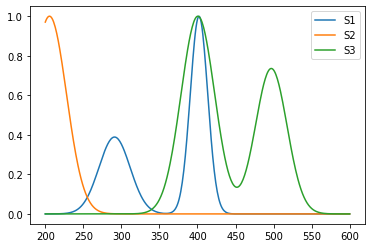

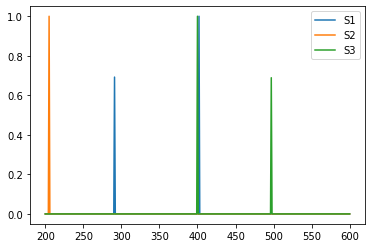

In [86]:
MIN_WL=200
MAX_WL=600
WL_INC=1
#np.random.seed(10)


def gauss_filter(sig, w,inc, x=None,renorm=True,target_area=None):
    sig_w  = w / (2 * np.sqrt(2 * np.log(2)))
    win = gaussian(int(1/inc * sig_w * 8), 1/inc * sig_w)
    conv=np.zeros_like(sig)
    if len(sig.shape) == 1:
        conv = signal.convolve(sig, win, mode='same')
    else:
        for i in range(sig.shape[0]):
            conv[i] = signal.convolve(sig[i], win, mode='same')
    if renorm:
        if target_area is not None:
            a0 = target_area
        else:
            a0=simps(y=sig,x=x)

        a=simps(y=conv,x=x)
        if a != 0:
            conv = conv*(a0/a)
    return conv

class ChromaSubstance():
    def __init__(self,name,spec_data=None):
        self.name = name
        if spec_data is None:
            spec_data = (MIN_WL+np.random.random(np.random.randint(1,4)*3)*(MAX_WL-MIN_WL)).reshape(-1,3)
            spec_data[:,1] = spec_data[:,1]/spec_data[:,1].sum()
            spec_data[:,2] = spec_data[:,2]/10

        self.spec_range=np.arange(MIN_WL,MAX_WL+WL_INC,WL_INC)
        self.spec_data=[]
        signalsconv = np.zeros_like(self.spec_range,dtype=float)
        for peak in spec_data:
            psignal = np.zeros_like(self.spec_range,dtype=float)
            t_index=np.argmin(np.abs(self.spec_range - peak[0]))
            psignal[t_index] = peak[1]
            self.spec_data.append(psignal)
            conv = gauss_filter(psignal,w=peak[2],inc=WL_INC,target_area=peak[1])
            signalsconv += conv

        self.spectrum = signalsconv/signalsconv.max()
        self.spec_data=np.array(self.spec_data)
        self.spec_data=self.spec_data/self.spec_data.max()

        self.columns_rs={}

    def __str__(self):
        return self.name
fronter = ChromaSubstance("Fronter")
cs1 = ChromaSubstance("S1")
cs2 = ChromaSubstance("S2")
cs3 = ChromaSubstance("S3")

plt.plot(cs1.spec_range,cs1.spectrum,label=cs1)
plt.plot(cs2.spec_range,cs2.spectrum,label=cs2)
plt.plot(cs3.spec_range,cs3.spectrum,label=cs3)
plt.legend()
plt.show()
plt.close()
plt.plot(cs1.spec_range,cs1.spec_data.sum(axis=0),label=cs1)
plt.plot(cs2.spec_range,cs2.spec_data.sum(axis=0),label=cs2)
plt.plot(cs3.spec_range,cs3.spec_data.sum(axis=0),label=cs3)
plt.legend()
plt.show()
plt.close()

In [87]:
substances = [fronter,cs1,cs2,cs3]
ini_conc = [0.1,1,0.5,0.8]
volume_concentration={
    k:[np.zeros_like(volumes[k],dtype=float) for s in substances] for k in available_edges

}
for (e0,e1) in available_edges:
    volume_concentration[(e1,e0)] = volume_concentration[(e0,e1)]

for i,c in enumerate(ini_conc):
    volume_concentration[(injection_loop.get_port(0),injection_loop.get_port(1))][i]+=c

In [88]:
for froms,tos in  injection_valve.switch().items():
    volume_concentration[tos] = volume_concentration[froms]

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in true_divide
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:221: RuntimeWarning: invalid value encountered in true_divide


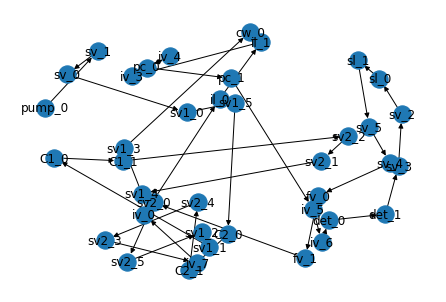

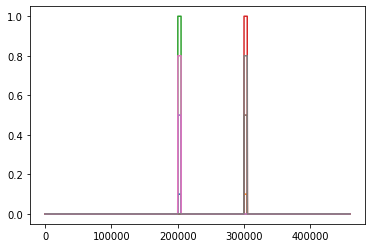

In [105]:
def get_full_vol(node,vol_data):
    port_pressures=fs.calc_pressures(to_nodes=True)
    g = fs.get_port_graph(with_flow=True)
    port_flow_graphs = [g.subgraph(c) for c in nx.connected_components(nx.to_undirected(g))]

    for pfg in port_flow_graphs:
        if nx.is_tree(pfg) and max((d for n, d in pfg.degree()))<=2:
            if node in pfg:
                vols=[]
                node_pressures=nx.get_node_attributes(pfg,'calc_pressure')
                nodes = [n for n  in sorted(node_pressures.keys(),key=lambda n:node_pressures[n],reverse=True)]

                nx.draw_spring(pfg,
                                   labels={node[0]:node[1].get('label',node[0]) for node in pfg.nodes(data=True)},
                                   )
                plt.show()
                plt.close()

                for i,n in enumerate(nodes):
                    if i==0:
                        continue
                    pn=nodes[i-1]
                    vols.append(vol_data[(pn,n)].copy())

                return np.concatenate(vols,axis=1)

def pump_vol(pump,vol):
    full_vol = get_full_vol(pump.port,volume_concentration)
    for i in range(len(full_vol)):
        plt.plot(full_vol[i])

        if vol > 0:
            s = int(vol*STEPS_PER_VOL)
            full_vol[i][s:]=full_vol[i][:-s]
            full_vol[i][:s]=0

        plt.plot(full_vol[i])
pump_vol(pump,100)

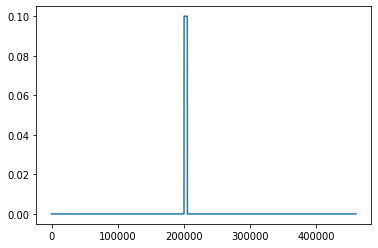

In [90]:
volume_concentration[(injection_loop.get_port(0),injection_loop.get_port(1))]

[array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]),
 array([0.8, 0.8, 0.8, ..., 0.8, 0.8, 0.8])]

In [91]:
full_vol[0].sum()

500.0000000000001

In [92]:
volume_concentration

{('port_0_19', 'port_1_7'): [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 ('port_0_7', 'port_0_20'): [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 ('port_1_7', 'port_0_7'): [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 ('port_2_7', 'port_0_8'): [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 ('port_3_7', 'port_2_7'): [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]